In [267]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# These are the data structures that we test.
# Each data structure is represented by a pair of a name and a color.
list = ("List", "#E56399")
listrev = ("ListRev", "#E66363")
sek = ("Sek", "#BC8BE7")
deque = ("Deque", "#7FD1B9")
steque = ("Steque", "#72A8B0")
cadeque = ("Cadeque", "#647FA6")
kot = ("KOT", "#FFAF02")

# We have .csv files whose naming convention is {data structure}-{operation}.csv
# If data_structures is a list of structure name / structure color pairs
# and operation is the name of an operation
# then read_data (data_structures, operation)
# yields the measurements for this operation on these data structures.
def read_data (data_structure, operation):
  name = data_structure[0]
  return pd.read_csv(f"./tmp/{name}-{operation}.csv")

# pd.concat(_, axis=1) performs horizontal concatenation of data frames.
def concat_read_data (data_structures, operation):
  return pd.concat(
    [ read_data(s, operation)
      for s in data_structures ],
    axis=1
  )

# My axis should display 10⁻¹ but you can switch to e-notation 1.00e+01
def log_tick_formatter(val, pos=None):
    return f"$10^{{{int(val)}}}$"  # remove int() if you don't use MaxNLocator
    # return f"{10**val:.2e}"      # e-Notation

plt.style.use('default')
linewidth = 1

In [275]:
# By convention, in the data frame [data], each successive
# line corresponds to a size group. There are two columns,
# named FooT and FooN, if the data structure is named Foo.
# FooT is a time; FooN is a number of repetitions.
# We transform this data into an array where the index is
# the number of the size group and the content is the time T/N.
def make_time_data_2D(data, name):
    times = data[name + "T"]
    repetitions = data[name + "N"]
    Y = []
    for time, repetition in zip(times, repetitions):
        if repetition == 0:
            Y.append(0.)
        else:
            Y.append(time / repetition)
    return np.array(Y)

# [target] is the name of the .pdf file that should be written.
def plot_time_data_2D(target, data, data_structures, ytop, scale='linear'):
    plt.xlim(0, 1)

    names = [n for n, _ in data_structures]
    colors = [c for _, c in data_structures]
    Ys = [make_time_data_2D(data, n) for n in names]

    buffers = len(Ys[0])
    X = np.arange(buffers)

    for n, c, Y in zip(names, colors, Ys):
        plt.scatter(X, Y, s=[15 for _ in X], color=c)
        plt.plot(Y, label=n, color=c, linewidth=linewidth)

    plt.xlabel("size group")
    plt.xticks(X, ["G" + str(i) for i in range(buffers)], rotation=45)

    # fig, ax = plt.subplots()
    plt.ylabel("time (µs)")
    plt.ylim(5.0e-4, ytop)
    plt.yscale(scale)

    plt.grid()
    plt.legend()
    plt.tight_layout()  # avoid a cropping problem with savefig
    plt.savefig(target) # save to file before showing
    plt.show()

# By convention, in the data frame [data], we have G^2 rows,
# and each row corresponds to a combination of two size groups:
# one group for the first argument of [concat],
# one group for its second argument.
# There are still two columns,
# named FooT and FooN, if the data structure is named Foo.
# FooT is a time; FooN is a number of repetitions.
# We transform this data into an array where the index is
# the number of the size group and the content is the time T/N.
def make_time_data_3D(data, name):
    times = data[name + "T"]
    repetitions = data[name + "N"]
    s = int (np.sqrt(len(times.to_list())))
    Z = []
    Zline = []
    for time, repetition in zip(times, repetitions):
        if repetition == 0:
            z = None
        else:
            z = time / repetition
        if len(Zline) == s:
            Z.append(Zline)
            Zline = [z]
        else:
            Zline.append(z)
    Z.append(Zline)
    Z = np.array(Z).astype(np.double)
    return Z, np.isfinite(Z)

def plot_time_data_3D(data, data_structures, view=None):
    names = [n for n, _ in data_structures]
    colors = [c for _, c in data_structures]
    Zs = [make_time_data_3D(data, n) for n in names]

    buffers = len(Zs[0][0])
    T = np.arange(buffers)
    S = np.array([[15 for _ in T] for _ in T])

    fig = plt.figure(figsize=(10., 10.))
    ax = fig.add_subplot(111, projection='3d')
    for n, c, (Z, Zmask) in zip(names, colors, Zs):
        for i in range(buffers):
            ax.scatter(np.full(buffers, i)[Zmask[i, :]], T[Zmask[i, :]], np.log10(Z[i, Zmask[i, :]]), s=S[i, Zmask[i, :]], color=c)
            ax.plot(np.full(buffers, i)[Zmask[i, :]], T[Zmask[i, :]], np.log10(Z[i, Zmask[i, :]]), color=c, linewidth=linewidth)
        for j in range(buffers):
            ax.scatter(T[Zmask[:, j]], np.full(buffers, j)[Zmask[:, j]], np.log10(Z[Zmask[:, j], j]), s=S[Zmask[:, j], j], color=c)
            ax.plot(T[Zmask[:, j]], np.full(buffers, j)[Zmask[:, j]], np.log10(Z[Zmask[:, j], j]), color=c, linewidth=linewidth)

    ax.set_xlabel("size group of the first argument")
    ax.invert_xaxis()
    ax.set_xticks(T, ["G" + str(i) for i in range(buffers)], rotation=45)
    ax.set_ylabel("size group of the second argument")
    ax.set_yticks(T, ["G" + str(i) for i in range(buffers)], rotation=-45)
    ax.set_zlabel("time (µs)")
    ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
    ax.zaxis.set_major_locator(mticker.MaxNLocator(integer=True))

    if view:
        ax.view_init(**view)

    plt.show()


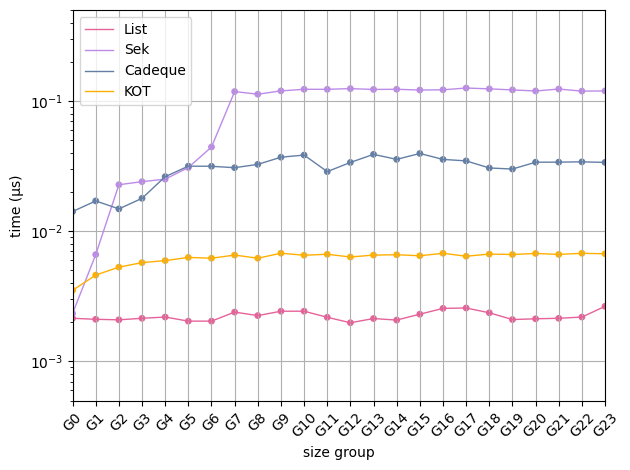

In [276]:
# Graph for push
data = concat_read_data([list, sek, cadeque, kot], "push")
plot_time_data_2D("./tmp/push.pdf", data, [list, sek, cadeque, kot], 5.0e-1, scale='log')

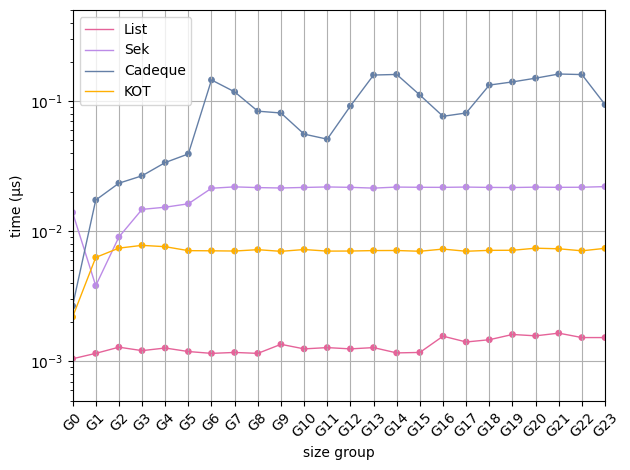

In [277]:
# Graph for pop
data = concat_read_data([list, sek, cadeque, kot], "pop")
plot_time_data_2D("./tmp/pop.pdf", data, [list, sek, cadeque, kot], 5.0e-1, scale='log')

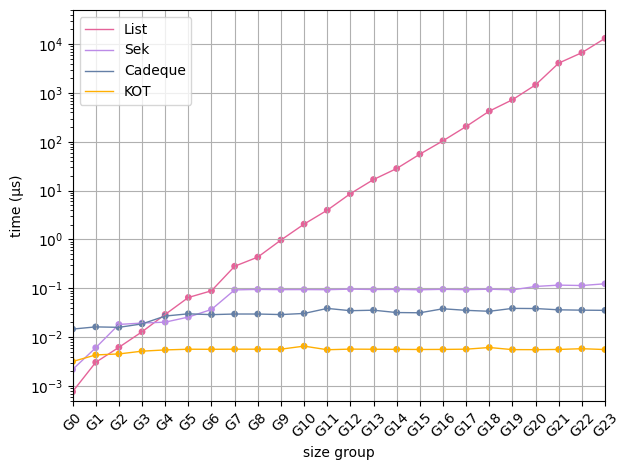

In [279]:
# Graph for inject
data = concat_read_data([list, sek, cadeque, kot], "inject")
plot_time_data_2D("./tmp/inject.pdf", data, [list, sek, cadeque, kot], 5.0e4, scale='log')

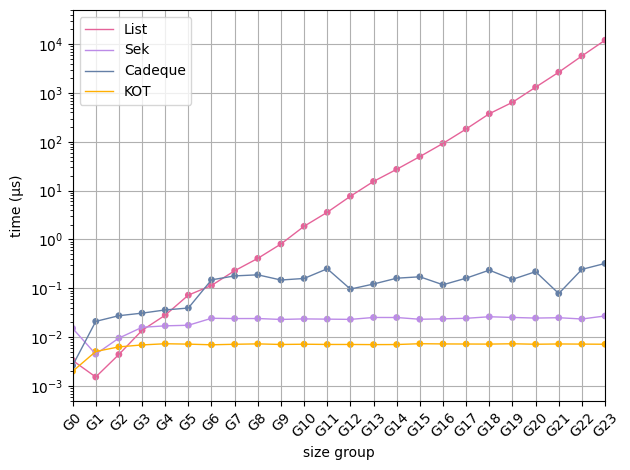

In [280]:
# Graph for eject
data = concat_read_data([list, sek, cadeque, kot], "eject")
plot_time_data_2D("./tmp/eject.pdf", data, [list, sek, cadeque, kot], 5.0e4, scale='log')

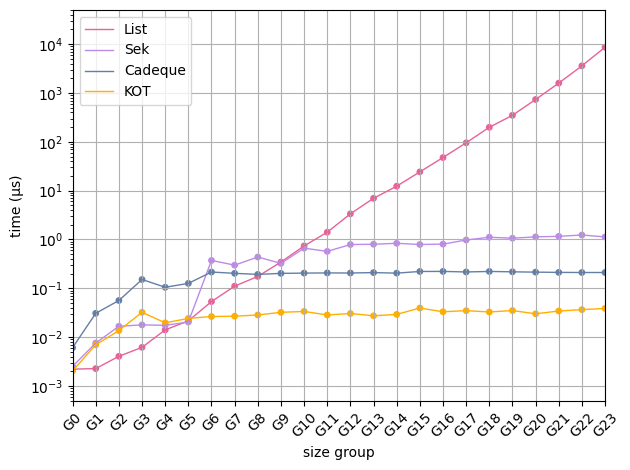

In [281]:
# Graph for concat (on the diagonal: the two arguments have roughly equal sizes)
data = concat_read_data([list, sek, cadeque, kot], "concat-diagonal")
plot_time_data_2D("./tmp/concat.pdf", data, [list, sek, cadeque, kot], 5.0e4, scale='log')

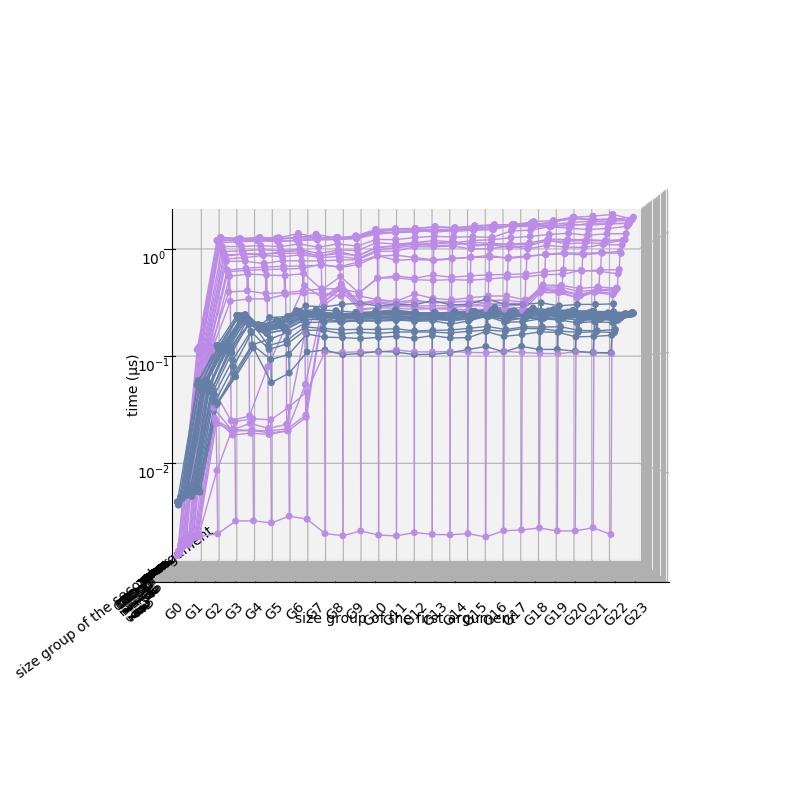

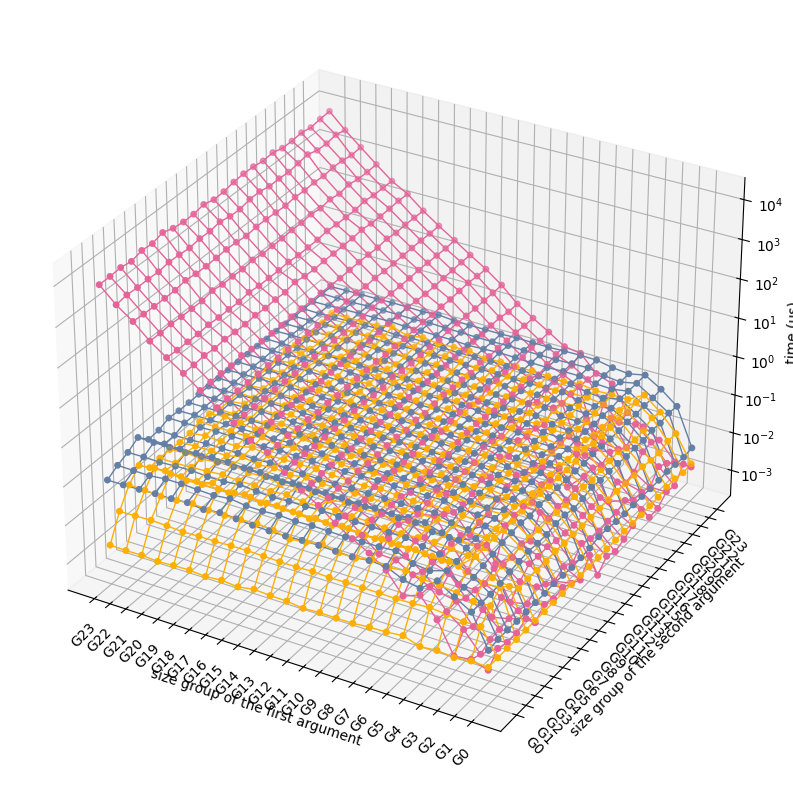

In [274]:
# Graph for concat
data = concat_read_data([list, sek, cadeque, kot], "concat")
view = {"elev" : 0, "azim" : 90, "roll" : 0}
# plot_time_data_3D(data, [list, sek, steque, cadeque, kot], view)
plot_time_data_3D(data, [sek, cadeque], view)
# plot_time_data_3D(data, [list, deque])
plot_time_data_3D(data, [list, cadeque, kot])